In [32]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

In [33]:
credit_score = pd.read_csv('../train.csv')
credit_score.info()

/tmp/ipykernel_16288/3843798550.py:1: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  credit_score = pd.read_csv('../train.csv')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 28 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   ID                        100000 non-null  object 
 1   Customer_ID               100000 non-null  object 
 2   Month                     100000 non-null  object 
 3   Name                      90015 non-null   object 
 4   Age                       100000 non-null  object 
 5   SSN                       100000 non-null  object 
 6   Occupation                100000 non-null  object 
 7   Annual_Income             100000 non-null  object 
 8   Monthly_Inhand_Salary     84998 non-null   float64
 9   Num_Bank_Accounts         100000 non-null  int64  
 10  Num_Credit_Card           100000 non-null  int64  
 11  Interest_Rate             100000 non-null  int64  
 12  Num_of_Loan               100000 non-null  object 
 13  Type_of_Loan              88592 non-null   ob

Removing weird values

In [34]:
credit_score['Occupation'] = credit_score['Occupation'].replace('_______', np.nan)
credit_score['Credit_Mix'] = credit_score['Credit_Mix'].replace('_', np.nan)
credit_score['Payment_Behaviour'] = credit_score['Payment_Behaviour'].replace('!@9#%8', np.nan)


Fix missing values in categorical data (Assumption is that customer didn't change their habits a lot in consecutive months)

In [35]:
categorical = ["Occupation", "Payment_Behaviour", "Month", "Credit_Mix", "Credit_History_Age" ,"Credit_Score", "Payment_of_Min_Amount"]

credit_score[categorical] = credit_score[categorical].astype("category")
credit_score[categorical] = credit_score.groupby("Customer_ID")[categorical].ffill()
credit_score[categorical] = credit_score.groupby("Customer_ID")[categorical].bfill()

In [36]:
split_type_of_loan = credit_score['Type_of_Loan'].str.replace('and ', '').str.split(', ')
# Get set of all types of loans
types_of_loans = set()
for row in split_type_of_loan:
    if type(row) == list:
        types_of_loans.update(row)

types_of_loans
# Create a row for every type of loan
credit_score["Type_of_Loan"].fillna("")
for loan in types_of_loans:
    credit_score[loan] = credit_score['Type_of_Loan'].str.contains(loan).astype(bool)

credit_score.drop(columns=['Type_of_Loan'], inplace=True)

Convert Credit History Age to int (Now age is represented in months)

In [37]:
credit_score["Credit_History_Age"] = credit_score["Credit_History_Age"].str.split(" ").apply(lambda x: int(x[0]) * 12 + int(x[3])).astype("Int16")

In [38]:
integer_cols = ["Age", "Num_Bank_Accounts", "Num_Credit_Card", "Num_of_Loan", "Interest_Rate", "Num_of_Delayed_Payment", "Num_Credit_Inquiries", "Delay_from_due_date"]
float_cols = ["Annual_Income", "Monthly_Balance", "Amount_invested_monthly", "Total_EMI_per_month", "Monthly_Inhand_Salary", "Changed_Credit_Limit", "Outstanding_Debt", "Credit_Utilization_Ratio"]

for col in integer_cols + float_cols:
    if credit_score[col].dtype == object:
        credit_score[col] = credit_score[col].str.replace('_', '')
        credit_score[col] = credit_score[col].replace('', np.nan)

for col in integer_cols:
    credit_score[col] = credit_score[col].astype("Int16")

for col in float_cols:
    credit_score[col] = credit_score[col].astype("float32")

In [39]:
def numeric_reassign_wrong_values_to_group_mode(df, groupby, column, inplace=False):
    """
    Function used to clean numeric attributes, it finds modes of each group and then finds minimum and maximum mode
    Then it assigns values outside of this range to NaN and fills them with mode of the group
    """
    import scipy.stats as stats 

    def get_group_correct_min_and_max(df: pd.DataFrame, groupby: str, column: str) -> tuple:
        """Identify correct range of values for the column by grouping by groupby column and calculating mode for each group"""
        cur = df[df[column].notna()].groupby(groupby)[column].apply(list)
        # Calculate modes for each group and return smalles and largest one
        min_mode, max_mode = cur.apply(lambda x: stats.mode(x).mode[0]).apply([min, max])
        return min_mode, max_mode
    
    # Assigning Wrong values
    def fill_group_with_mode(df, groupby, column, inplace=False):
        mini, maxi = get_group_correct_min_and_max(df, groupby, column)

        # assign incorrect values to NaN
        col = df[column].apply(lambda x: np.nan if ((x<mini)|(x>maxi)) else x)

        # fill with local mode
        mode_by_group = df.groupby(groupby)[column].transform(lambda x: x.mode()[0] if not x.mode().empty else np.NaN)
        result = col.fillna(mode_by_group)

        # inplace
        if inplace:
            df[column]=result
        else:
            return result
        
    # Run      
    if inplace:   
        # Before Assigning NaN values   
        if df[column].value_counts(dropna=False).index.isna().sum():
            x = df[column].value_counts(dropna=False).loc[[np.nan]]
            print(f'\nBefore Assigning: {column}:', f'have {x.values[0]} NaN Values', end='\n')
            
        print("\nExisting Min, Max Values:", df[column].apply([min, max]), sep='\n', end='\n')       
        
        mini, maxi = get_group_correct_min_and_max(df, groupby, column)        
        print(f"\nGroupby by {groupby}'s Correct min, max Values:", f'min:\t{mini},\nmax:\t{ maxi}', sep='\n', end='\n')        
        
        a = df.groupby(groupby)[column].apply(list) 
        print(f'\nBefore Assigning Example {column}:\n', *a.head().values, sep='\n', end='\n')
        
        # Assigning
        fill_group_with_mode(df, groupby, column, inplace)
        
        # After Assigning NaN values
        if df[column].value_counts(dropna=False).index.isna().sum():
            y = df[column].value_counts(dropna=False).loc[[np.NaN]]
            print(f'\nBefore Assigning: {column}:', f'have {y.values[0]} NaN Values', end='\n')
        
        b = df.groupby(groupby)[column].apply(list)
        print(f'\nAfter Assigning Example {column}:\n', *b.head().values, sep='\n', end='\n')
    else:   
        # Show
        return fill_group_with_mode(df, groupby, column, inplace)
    

In [40]:
credit_score["Num_of_Delayed_Payment"] = credit_score["Num_of_Delayed_Payment"].fillna(0)
credit_score["Num_of_Delayed_Payment"] = credit_score["Num_of_Delayed_Payment"].apply(lambda x: np.nan if x<0 else x)
credit_score["Num_Credit_Inquiries"] = credit_score["Num_Credit_Inquiries"].fillna(0)
credit_score["Num_Credit_Inquiries"] = credit_score["Num_Credit_Inquiries"].apply(lambda x: np.nan if x<0 else x)

numeric_reassign_wrong_values_to_group_mode(credit_score, "Customer_ID", "Num_Credit_Inquiries", inplace=True)

for col in integer_cols:
    if col == "Delay_from_due_date":
        continue
    numeric_reassign_wrong_values_to_group_mode(credit_score, "Customer_ID", col, inplace=True)


Existing Min, Max Values:
min       0
max    2597
Name: Num_Credit_Inquiries, dtype: int64


/tmp/ipykernel_16288/2815273798.py:12: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  min_mode, max_mode = cur.apply(lambda x: stats.mode(x).mode[0]).apply([min, max])



Groupby by Customer_ID's Correct min, max Values:
min:	0,
max:	17

Before Assigning Example Num_Credit_Inquiries:

[10, 11, 11, 11, 11, 11, 11, 11]
[2, 2, 2, 2, 4, 4, 4, 4]
[1, 2271, 1, 1, 1, 1, 4, 4]
[7, 7, 7, 7, 1965, 7, 7, 7]
[3, 3, 3, 3, 3, 3, 3, 3]


/tmp/ipykernel_16288/2815273798.py:12: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  min_mode, max_mode = cur.apply(lambda x: stats.mode(x).mode[0]).apply([min, max])



After Assigning Example Num_Credit_Inquiries:

[10.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0]
[2.0, 2.0, 2.0, 2.0, 4.0, 4.0, 4.0, 4.0]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 4.0, 4.0]
[7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0]
[3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0]

Before Assigning: Age: have 0 NaN Values

Existing Min, Max Values:
min    -500
max    8698
Name: Age, dtype: int16


/tmp/ipykernel_16288/2815273798.py:12: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  min_mode, max_mode = cur.apply(lambda x: stats.mode(x).mode[0]).apply([min, max])



Groupby by Customer_ID's Correct min, max Values:
min:	14,
max:	56

Before Assigning Example Age:

[17, 17, 17, 17, 17, 18, 18, 18]
[25, 25, 26, 26, 26, 26, 26, 26]
[18, 18, 18, 18, 19, 19, 19, 19]
[43, 44, 44, 44, 44, 44, 44, 44]
[43, 43, 44, 44, 44, 44, 44, 44]


/tmp/ipykernel_16288/2815273798.py:12: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  min_mode, max_mode = cur.apply(lambda x: stats.mode(x).mode[0]).apply([min, max])



After Assigning Example Age:

[17.0, 17.0, 17.0, 17.0, 17.0, 18.0, 18.0, 18.0]
[25.0, 25.0, 26.0, 26.0, 26.0, 26.0, 26.0, 26.0]
[18.0, 18.0, 18.0, 18.0, 19.0, 19.0, 19.0, 19.0]
[43.0, 44.0, 44.0, 44.0, 44.0, 44.0, 44.0, 44.0]
[43.0, 43.0, 44.0, 44.0, 44.0, 44.0, 44.0, 44.0]

Before Assigning: Num_Bank_Accounts: have 0 NaN Values

Existing Min, Max Values:
min      -1
max    1798
Name: Num_Bank_Accounts, dtype: int16


/tmp/ipykernel_16288/2815273798.py:12: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  min_mode, max_mode = cur.apply(lambda x: stats.mode(x).mode[0]).apply([min, max])



Groupby by Customer_ID's Correct min, max Values:
min:	-1,
max:	10

Before Assigning Example Num_Bank_Accounts:

[6, 6, 6, 6, 6, 6, 6, 6]
[6, 6, 6, 6, 6, 6, 6, 6]
[1, 1, 1, 1, 1, 1, 1, 1]
[3, 3, 3, 3, 3, 3, 3, 3]
[3, 3, 3, 3, 3, 3, 3, 3]


/tmp/ipykernel_16288/2815273798.py:12: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  min_mode, max_mode = cur.apply(lambda x: stats.mode(x).mode[0]).apply([min, max])



After Assigning Example Num_Bank_Accounts:

[6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0]
[6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0]
[3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0]

Before Assigning: Num_Credit_Card: have 0 NaN Values

Existing Min, Max Values:
min       0
max    1499
Name: Num_Credit_Card, dtype: int16


/tmp/ipykernel_16288/2815273798.py:12: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  min_mode, max_mode = cur.apply(lambda x: stats.mode(x).mode[0]).apply([min, max])



Groupby by Customer_ID's Correct min, max Values:
min:	0,
max:	11

Before Assigning Example Num_Credit_Card:

[5, 5, 5, 5, 5, 5, 5, 5]
[5, 5, 5, 5, 5, 5, 5, 5]
[4, 4, 4, 4, 4, 4, 4, 4]
[3, 3, 3, 3, 3, 3, 3, 3]
[3, 3, 3, 3, 3, 3, 3, 3]


/tmp/ipykernel_16288/2815273798.py:12: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  min_mode, max_mode = cur.apply(lambda x: stats.mode(x).mode[0]).apply([min, max])



After Assigning Example Num_Credit_Card:

[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0]
[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0]
[4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0]
[3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0]
[3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0]

Before Assigning: Num_of_Loan: have 0 NaN Values

Existing Min, Max Values:
min    -100
max    1496
Name: Num_of_Loan, dtype: int16


/tmp/ipykernel_16288/2815273798.py:12: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  min_mode, max_mode = cur.apply(lambda x: stats.mode(x).mode[0]).apply([min, max])



Groupby by Customer_ID's Correct min, max Values:
min:	0,
max:	9

Before Assigning Example Num_of_Loan:

[2, 2, 2, 2, 2, 2, 2, 2]
[4, 4, 4, 1094, 4, 4, 4, 4]
[0, 0, 0, 0, 0, 0, 0, 0]
[3, 3, 3, 3, 3, 3, 3, 3]
[3, 3, 3, 3, 3, 3, 3, 3]


/tmp/ipykernel_16288/2815273798.py:12: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  min_mode, max_mode = cur.apply(lambda x: stats.mode(x).mode[0]).apply([min, max])



After Assigning Example Num_of_Loan:

[2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0]
[4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0]
[3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0]

Before Assigning: Interest_Rate: have 0 NaN Values

Existing Min, Max Values:
min       1
max    5797
Name: Interest_Rate, dtype: int16


/tmp/ipykernel_16288/2815273798.py:12: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  min_mode, max_mode = cur.apply(lambda x: stats.mode(x).mode[0]).apply([min, max])



Groupby by Customer_ID's Correct min, max Values:
min:	1,
max:	34

Before Assigning Example Interest_Rate:

[27, 27, 27, 27, 27, 27, 27, 27]
[17, 17, 17, 17, 17, 17, 17, 17]
[1, 1, 1, 1, 1, 1, 1, 1]
[17, 17, 17, 17, 17, 17, 17, 17]
[6, 6, 6, 6, 6, 6, 6, 6]


/tmp/ipykernel_16288/2815273798.py:12: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  min_mode, max_mode = cur.apply(lambda x: stats.mode(x).mode[0]).apply([min, max])



After Assigning Example Interest_Rate:

[27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0]
[17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0]
[6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0]

Before Assigning: Num_of_Delayed_Payment: have 644 NaN Values

Existing Min, Max Values:
min       0.0
max    4397.0
Name: Num_of_Delayed_Payment, dtype: float64


/tmp/ipykernel_16288/2815273798.py:12: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  min_mode, max_mode = cur.apply(lambda x: stats.mode(x).mode[0]).apply([min, max])



Groupby by Customer_ID's Correct min, max Values:
min:	0.0,
max:	28.0

Before Assigning Example Num_of_Delayed_Payment:

[25.0, 23.0, 28.0, 25.0, 25.0, 23.0, 25.0, 26.0]
[1749.0, 16.0, 18.0, 18.0, 19.0, 18.0, 18.0, 18.0]
[7.0, 9.0, 7.0, 7.0, 7.0, 7.0, 7.0, 8.0]
[12.0, 0.0, 17.0, 15.0, 0.0, 15.0, 15.0, 13.0]
[9.0, 9.0, 9.0, 7.0, 9.0, 7.0, 9.0, 0.0]


/tmp/ipykernel_16288/2815273798.py:12: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  min_mode, max_mode = cur.apply(lambda x: stats.mode(x).mode[0]).apply([min, max])



After Assigning Example Num_of_Delayed_Payment:

[25.0, 23.0, 28.0, 25.0, 25.0, 23.0, 25.0, 26.0]
[18.0, 16.0, 18.0, 18.0, 19.0, 18.0, 18.0, 18.0]
[7.0, 9.0, 7.0, 7.0, 7.0, 7.0, 7.0, 8.0]
[12.0, 0.0, 17.0, 15.0, 0.0, 15.0, 15.0, 13.0]
[9.0, 9.0, 9.0, 7.0, 9.0, 7.0, 9.0, 0.0]

Existing Min, Max Values:
min     0.0
max    17.0
Name: Num_Credit_Inquiries, dtype: float64


/tmp/ipykernel_16288/2815273798.py:12: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  min_mode, max_mode = cur.apply(lambda x: stats.mode(x).mode[0]).apply([min, max])



Groupby by Customer_ID's Correct min, max Values:
min:	0.0,
max:	17.0

Before Assigning Example Num_Credit_Inquiries:

[10.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0]
[2.0, 2.0, 2.0, 2.0, 4.0, 4.0, 4.0, 4.0]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 4.0, 4.0]
[7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0]
[3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0]


/tmp/ipykernel_16288/2815273798.py:12: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  min_mode, max_mode = cur.apply(lambda x: stats.mode(x).mode[0]).apply([min, max])



After Assigning Example Num_Credit_Inquiries:

[10.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0]
[2.0, 2.0, 2.0, 2.0, 4.0, 4.0, 4.0, 4.0]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 4.0, 4.0]
[7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0]
[3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0]


In [41]:
credit_score[credit_score["Num_of_Delayed_Payment"] < 0][["Customer_ID", "Num_of_Delayed_Payment"]]

,Customer_ID,Num_of_Delayed_Payment


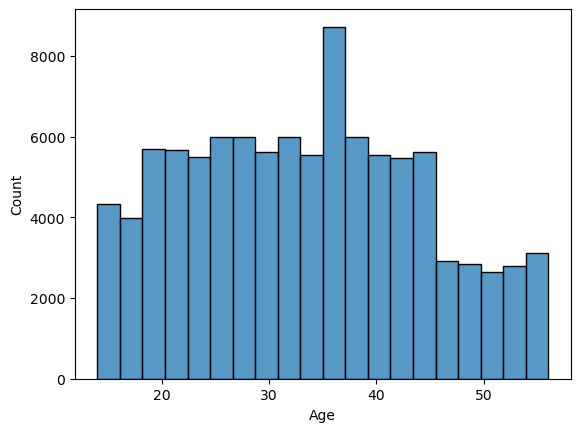

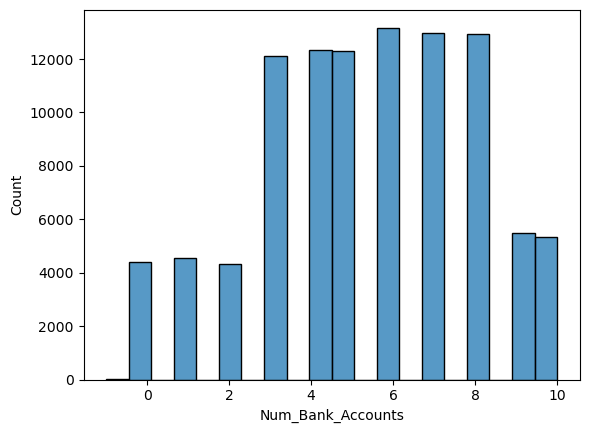

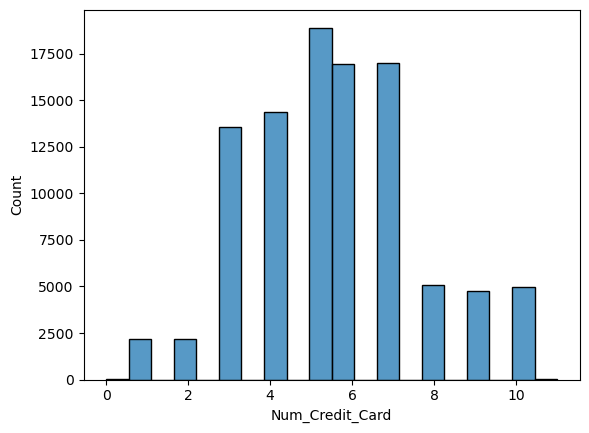

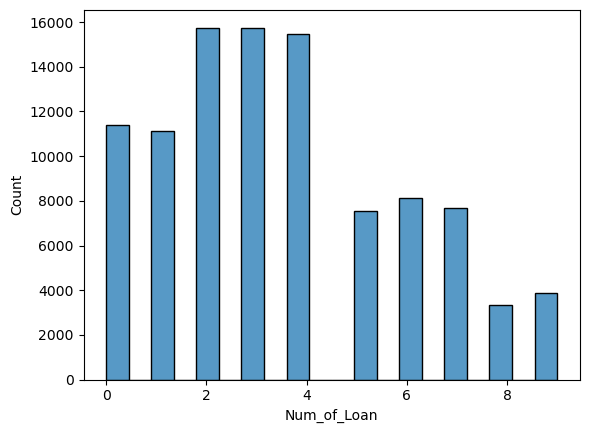

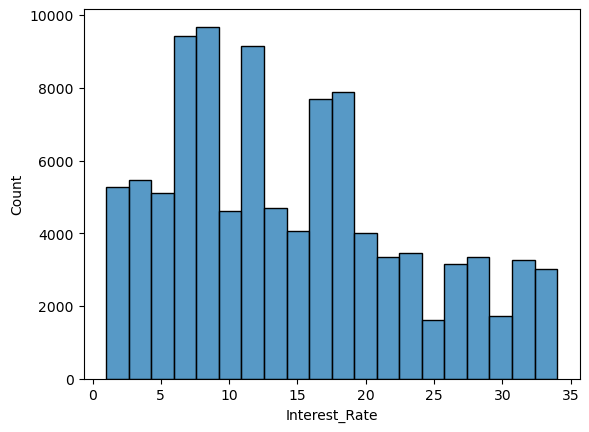

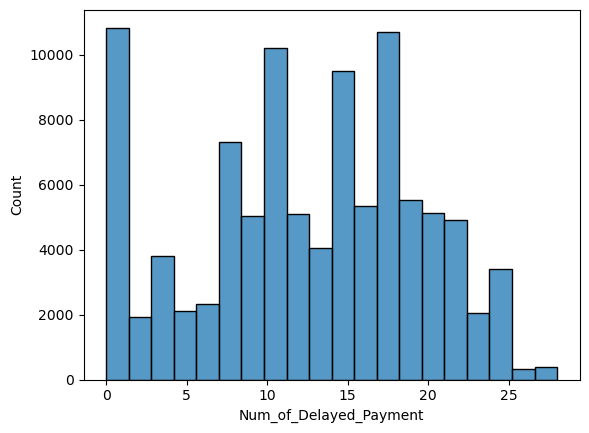

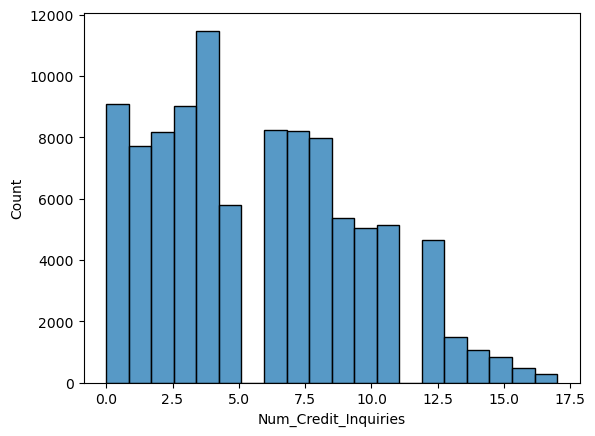

/home/adam/var/apps/miniconda3/envs/data-mining/lib/python3.10/site-packages/seaborn/distributions.py:499: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pd.Index(edges, name="edges"),
/home/adam/var/apps/miniconda3/envs/data-mining/lib/python3.10/site-packages/seaborn/distributions.py:500: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pd.Index(widths, name="widths"),


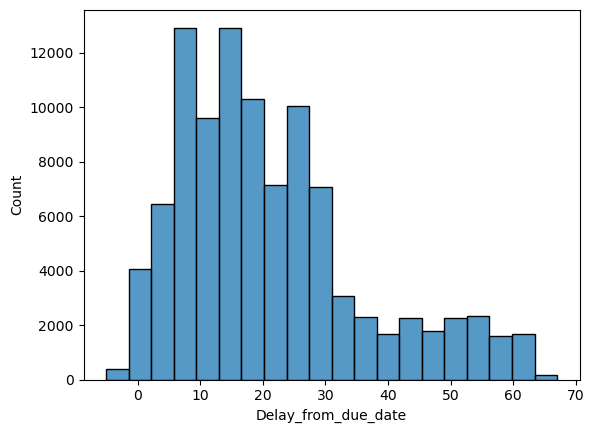

In [42]:
for col in integer_cols:
    sns.histplot(credit_score[col], bins=20)
    plt.show()

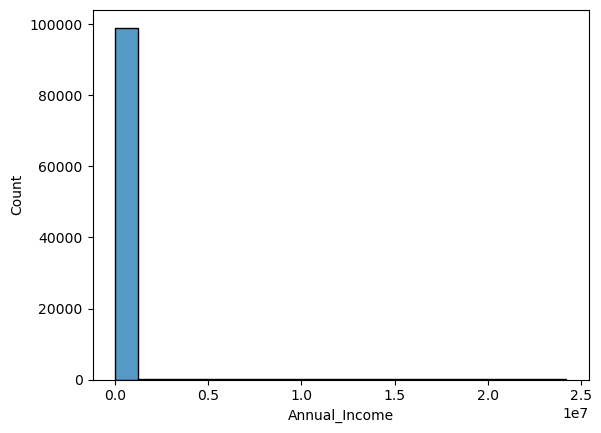

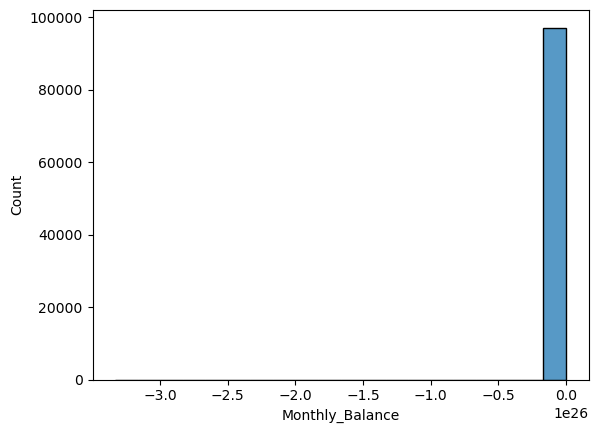

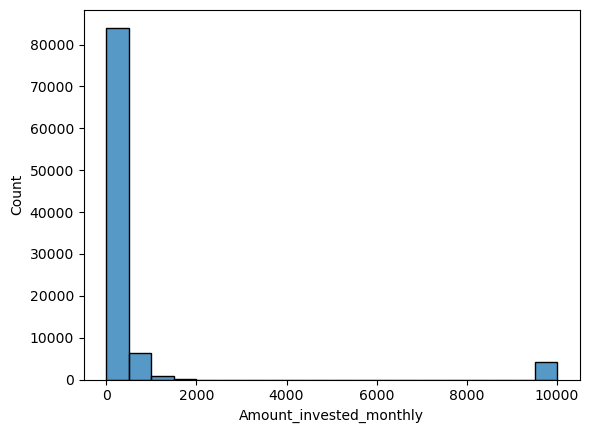

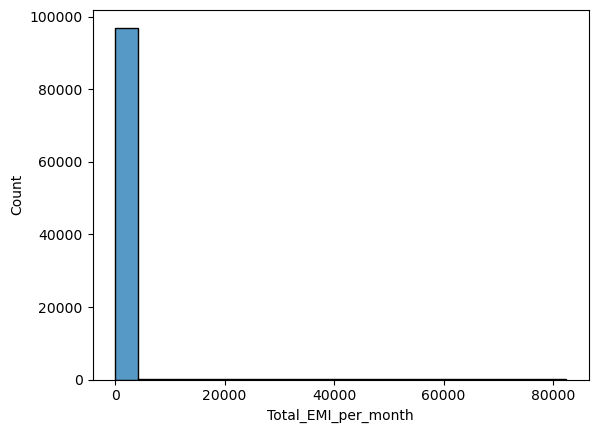

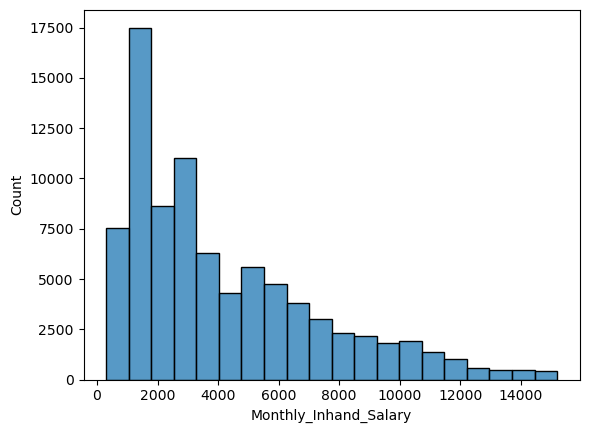

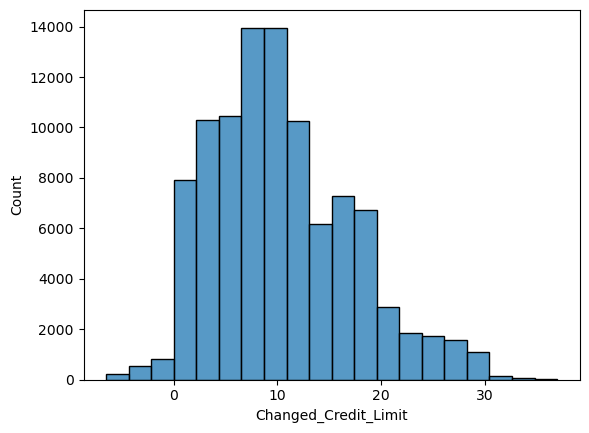

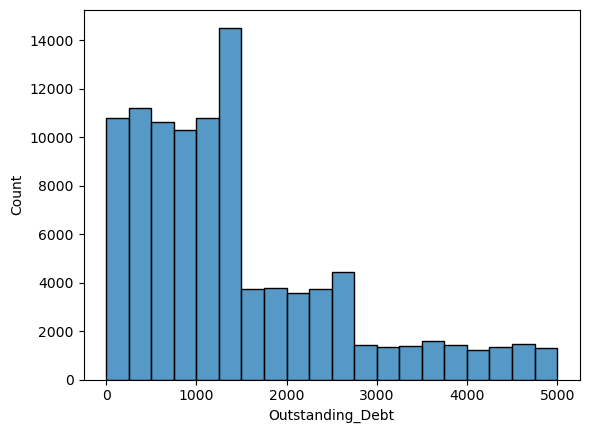

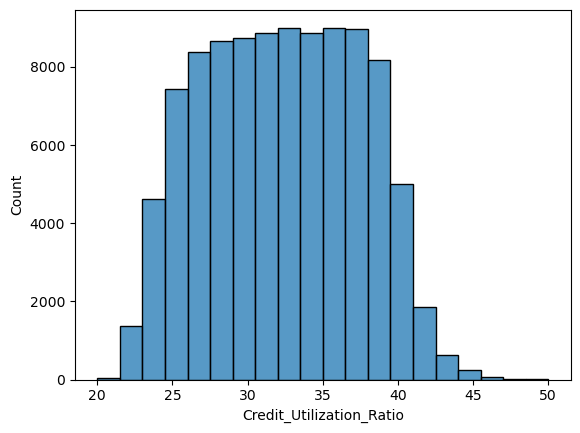

In [43]:
for col in float_cols:
    sns.histplot(credit_score[col], bins=20)
    plt.show()

There are problems with: "Annual_Income", "Amount_invested_monthly", "Monthly_Balance", "Total_EMI_per_month"

In [44]:
# Get percentile of Annual_income
top = credit_score["Annual_Income"].quantile(0.985)
credit_score[credit_score["Annual_Income"] > top]

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Credit_Score,Student Loan,Debt Consolidation Loan,Not Specified,Mortgage Loan,Credit-Builder Loan,Auto Loan,Personal Loan,Home Equity Loan,Payday Loan
54,0x1650,CUS_0x284a,July,Nadiaq,34.0,#F%$D@*&8,Lawyer,10909427.0,NaN,0.0,...,Good,False,False,False,True,True,False,False,False,False
231,0x1759,CUS_0xbffe,August,Dhanya Skariachano,40.0,311-13-7309,Architect,6515990.0,2210.032471,6.0,...,Standard,False,False,True,False,False,True,False,False,True
245,0x176f,CUS_0x9a71,June,NaN,55.0,889-07-2357,Scientist,586359.0,1684.168335,1.0,...,Good,False,False,False,False,False,True,False,True,False
361,0x181f,CUS_0x8e9b,February,Rachelle Younglaic,15.0,925-51-5335,Entrepreneur,18334118.0,4369.482422,10.0,...,Standard,True,True,True,False,False,False,True,True,True
368,0x182a,CUS_0x609d,January,NaN,27.0,911-47-6879,Architect,19717384.0,1057.435791,7.0,...,Standard,True,False,False,True,True,False,True,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99664,0x25dfa,CUS_0xb09,January,Lianau,31.0,228-47-4867,Lawyer,5794377.0,NaN,5.0,...,Standard,False,True,False,False,False,False,False,False,False
99714,0x25e44,CUS_0xadbd,March,Scotts,26.0,864-24-3672,Doctor,11712577.0,NaN,5.0,...,Standard,False,False,True,False,False,False,True,False,True
99721,0x25e4f,CUS_0x11c7,February,raden Reddallh,53.0,646-19-1493,Architect,8544730.0,3198.161621,5.0,...,Standard,False,False,False,True,False,True,False,True,False
99882,0x25f40,CUS_0x47fa,March,Yantoultra Nguif,31.0,291-51-7240,Mechanic,16884796.0,5440.944824,7.0,...,Standard,True,True,True,True,True,True,True,True,True


In [45]:
credit_score["Annual_Income"] = credit_score["Annual_Income"].apply(lambda x: np.nan if x > top else x)

In [46]:
top = credit_score["Amount_invested_monthly"].quantile(0.95)
credit_score[credit_score["Amount_invested_monthly"] > top]
credit_score["Amount_invested_monthly"] = credit_score["Amount_invested_monthly"].apply(lambda x: np.nan if x > top else x)


In [47]:
bottom = credit_score["Monthly_Balance"].quantile(0.005)
credit_score[credit_score["Monthly_Balance"] < bottom]
credit_score["Monthly_Balance"] = credit_score["Monthly_Balance"].apply(lambda x: np.nan if x < bottom else x)


In [48]:
top = credit_score["Total_EMI_per_month"].quantile(0.98)
credit_score[credit_score["Total_EMI_per_month"] > top]
credit_score["Total_EMI_per_month"] = credit_score["Total_EMI_per_month"].apply(lambda x: np.nan if x > top else x)


In [49]:
problematic = ["Annual_Income", "Amount_invested_monthly", "Monthly_Balance", "Total_EMI_per_month"]
credit_score[problematic] = credit_score.groupby("Customer_ID")[problematic].ffill()
credit_score[problematic] = credit_score.groupby("Customer_ID")[problematic].bfill()

for col in problematic:
    print(credit_score[col].isna().sum())

# Fill na with median
credit_score = credit_score.fillna(credit_score.median())

504
0
1696
0


/tmp/ipykernel_16288/3250363510.py:9: FutureWarning: The default value of numeric_only in DataFrame.median is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  credit_score = credit_score.fillna(credit_score.median())


Drop unnecessary columns

In [50]:
credit_score.drop(columns=['ID', 'Customer_ID', 'Name', 'SSN'], inplace=True)

In [51]:
credit_score.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 32 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   Month                     100000 non-null  category
 1   Age                       100000 non-null  float64 
 2   Occupation                100000 non-null  category
 3   Annual_Income             100000 non-null  float64 
 4   Monthly_Inhand_Salary     100000 non-null  float32 
 5   Num_Bank_Accounts         100000 non-null  float64 
 6   Num_Credit_Card           100000 non-null  float64 
 7   Interest_Rate             100000 non-null  float64 
 8   Num_of_Loan               100000 non-null  float64 
 9   Delay_from_due_date       100000 non-null  Int16   
 10  Num_of_Delayed_Payment    100000 non-null  float64 
 11  Changed_Credit_Limit      100000 non-null  float32 
 12  Num_Credit_Inquiries      100000 non-null  float64 
 13  Credit_Mix                1000

In [ ]:
credit_score.to_feather("credit_score_cleaned.feather")